<a href="https://colab.research.google.com/github/SvenPfiffner/Algorithms-and-Datastructures/blob/master/BodySegmentation/BodySegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: [Sven Pfiffner](svenp@ethz.ch). 
[[GitHub](https://github.com/SvenPfiffner/RR-Aesthetics)]
# Perform body segmentation and background inpainting
This notebook deals with the problem of body segmentation and removal of the subject with inpainting the resulting "hole"

### Sources

* Mediapipe:  https://mediapipe.dev/ [[GitHub](https://github.com/google/mediapipe)]
* CO-MOD-GAN: [[GitHub](https://github.com/zsyzzsoft/co-mod-gan)]

#### Papers
Theoretical background can be found in the following papers
* [Large Scale Image Completition Via Comodulated Generative Adverserial Networks](https://openreview.net/pdf?id=sSjqmfsk95O)

## Code


### The CO-MOD-GAN inpainting relies on Tensorflow 1.x.
As this is no longer supported by Colab I can sadly not include it in this notebook. Run the GitHub project of co-mod-gan to perform inpainting with GAN

### Download model and prepare mediapipe requirements

In [2]:
!pip install -q flatbuffers==2.0.0
!pip install -q mediapipe==0.9.1
!wget -O deeplabv3.tflite -q https://storage.googleapis.com/mediapipe-assets/deeplabv3.tflite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 33.7 MB/s eta 0:00:00


In [45]:
# Imports
import mediapipe as mp
import mediapipe.tasks as mpt
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
from os import listdir
from os.path import isfile, join
from scipy.signal import convolve2d

# Prepare model usage
model_path = "/content/deeplabv3.tflite"

BaseOptions = mpt.BaseOptions
ImageSegmenter = vision.ImageSegmenter
ImageSegmenterOptions = vision.ImageSegmenterOptions
VisionRunningMode = vision.RunningMode

# Create a image segmenter instance with the image mode:
options = ImageSegmenterOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE,
    output_type=ImageSegmenterOptions.OutputType.CATEGORY_MASK)


### Upload and prepare image
You can either upload an image or specify the path to an existing image in your
google drive or from a given `img_dir`. Behaviour is determined by the `img_use_existing` flag

In [122]:
img_use_existing = False
img_dir = '/content/gdrive/MyDrive/Thesis/img'

!mkdir -p /content/img

if not img_use_existing:
  !rm -f /content/img/*
  %cd /content/img
  from google.colab import files
  uploaded = files.upload()
  %cd /content
else:
  from google.colab import drive
  drive.mount('/content/drive')
  !rm -f /content/img/*
  !cp -a {img_dir}/* /content/img

# Get path to specified image
files = [join("/content/img", f) for f in listdir("/content/img") if isfile(join("/content/img", f))]

# Load the input image from an image file.
mp_image = mp.Image.create_from_file(files[0])


/content/img


Saving male.jpg to male.jpg
/content


### Perform segmentation

In [123]:
with ImageSegmenter.create_from_options(options) as segmenter:
  # Perform image segmentation on the provided single image.
  segmented_masks = segmenter.segment(mp_image)

In [124]:
#@title Set mask dilation
#@markdown Note that we should use dilation on the mask to make sure we remove all of the foreground. It does not matter if we remove to much bachground as we use inpainting anyway
dilate_mask = True #@param {type:"boolean"}
dilation_strength = 0.7 #@param {type:"slider", min:0, max:1, step:0.1}

In [128]:
def dilate(mask, strength):
  # Binarize the given mask
  bin_mask = cv2.threshold(mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  
  # Create a dilation kernel that is all ones
  # to dilate in all directions.
  kernel = np.ones((5, 5), np.uint8)
  
  # Dilate with dilation iterations determined by dilation strength
  out = cv2.dilate(bin_mask, kernel, iterations=int(strength * 10.0))

  return out

### Visualize mask

In [129]:
# Helper method that resizes a given image and shows it in the notebook
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

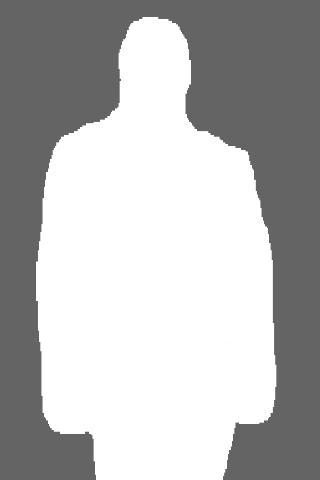

In [130]:
if dilate_mask:
  mask = dilate(segmented_masks[0].numpy_view(), dilation_strength)
else:
  mask = segmented_masks[0].numpy_view()

BG_COLOR = (100, 100, 100) # gray
MASK_COLOR = (255, 255, 255) # white

OutputType = vision.ImageSegmenterOptions.OutputType
Activation = vision.ImageSegmenterOptions.Activation

# Generate solid color images for showing the output segmentation mask.
image_data = mp_image.numpy_view()
fg_image = np.zeros(image_data.shape, dtype=np.uint8)
fg_image[:] = MASK_COLOR
bg_image = np.zeros(image_data.shape, dtype=np.uint8)
bg_image[:] = BG_COLOR
condition = np.stack((mask,) * 3, axis=-1) > 0.2
output_image = np.where(condition, fg_image, bg_image)

resize_and_show(output_image)

### Remove masked foreground object from image

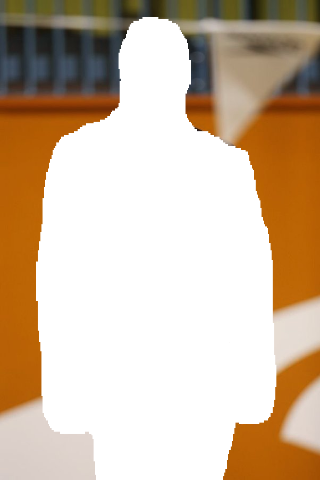

In [131]:
if dilate_mask:
  mask = dilate(segmented_masks[0].numpy_view(), dilation_strength)
else:
  mask = segmented_masks[0].numpy_view()

image_data = mp_image.numpy_view()
fg_image = np.zeros(image_data.shape, dtype=np.uint8)
fg_image[:] = MASK_COLOR
condition = np.stack((mask,) * 3, axis=-1) > mask_tol
image_subject_removed = np.where(condition, fg_image, image_data)

resize_and_show(image_subject_removed)

### Inpaint background lazily

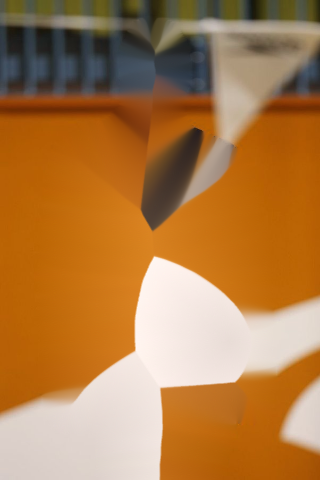

In [132]:
if dilate_mask:
  mask = dilate(segmented_masks[0].numpy_view(), dilation_strength)
else:
  mask = segmented_masks[0].numpy_view()

image_data = mp_image.numpy_view()
dst = cv2.inpaint(image_data,mask,3,cv2.INPAINT_TELEA)
resize_and_show(dst)

### Inpainting with GAN
See https://github.com/zsyzzsoft/co-mod-gan